[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hamid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hamid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading dataset...
Previewing the dataset:
                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0
Starting parallel text cleaning...
Text cleaning completed.
Encoding labels...
Extracting features using TF-IDF...
Splitting the dataset into training and testing sets...
Training Naive Bayes models in parallel...
Making predictions with the trained models...
Evaluating models...
Best Model Accuracy: 95.30%
Calculating precision, recall, F1 score, and confusion matrix for the best model...
Precision: 95.43%
Recall: 95.30%
F1 Score: 95.25%
Plotting confusion matrix...


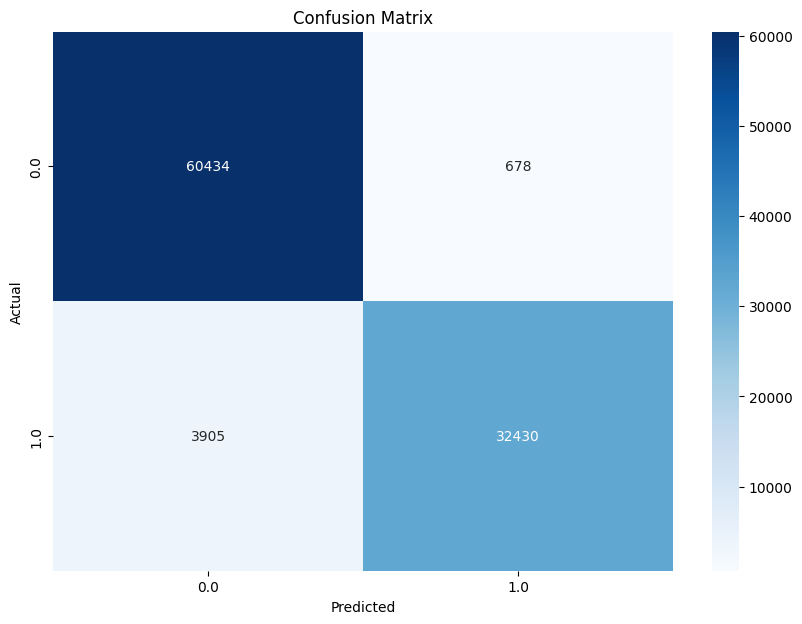

Saving the best model to a file...
Model saved successfully.


In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor

# Download NLTK data
print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
print("Loading dataset...")
df = pd.read_csv('AI_Human.csv')  # Update the file path accordingly

# Preview the dataset
print("Previewing the dataset:")
print(df.head())

# Text cleaning function
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove all non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    return text

# Tokenization and removing stopwords
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Define a function for parallel text cleaning using multi-threading
def parallel_cleaning(df):
    print("Starting parallel text cleaning...")
    num_workers = os.cpu_count()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        df['text'] = list(executor.map(clean_text, df['text']))
        df['text'] = list(executor.map(tokenize_and_remove_stopwords, df['text']))
    print("Text cleaning completed.")
    return df

# Apply text cleaning
df = parallel_cleaning(df)

# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
df['generated'] = label_encoder.fit_transform(df['generated'])

# Feature extraction using TF-IDF
print("Extracting features using TF-IDF...")
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['text'])
y = df['generated']

# Split the dataset into training and testing sets
print("Splitting the dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a function for training Naive Bayes model
def train_naive_bayes(X_train, y_train):
    naive_bayes = MultinomialNB()
    naive_bayes.fit(X_train, y_train)
    return naive_bayes

# Parallelize training using multi-threading
print("Training Naive Bayes models in parallel...")
num_workers = os.cpu_count()
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    models = list(executor.map(lambda _: train_naive_bayes(X_train, y_train), range(num_workers)))

# Predict using the trained models
print("Making predictions with the trained models...")
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    y_preds = list(executor.map(lambda model: model.predict(X_test), models))

# Combine predictions and evaluate each model
print("Evaluating models...")
accuracies = [accuracy_score(y_test, y_pred) for y_pred in y_preds]

# Get the best model (highest accuracy)
best_model_index = np.argmax(accuracies)
best_model = models[best_model_index]
best_accuracy = accuracies[best_model_index]

print(f'Best Model Accuracy: {best_accuracy * 100:.2f}%')

# Evaluate best model
print("Calculating precision, recall, F1 score, and confusion matrix for the best model...")
y_pred_best = best_model.predict(X_test)
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_best)

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Plot confusion matrix
print("Plotting confusion matrix...")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the best model to a file
print("Saving the best model to a file...")
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model saved successfully.")
